In [365]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


# RUN BLR

In [366]:
! rm -r '/Users/ltran/Documents/TrueData0104/CPC_ML_tutorial/models/test/'
! mkdir '/Users/ltran/Documents/TrueData0104/CPC_ML_tutorial/models/test/'

In [367]:
import os
os.chdir('/Users/ltran/Documents/TrueData29/CPC_ML_tutorial/')

import numpy as np
import pandas as pd
import pickle
from matplotlib import pyplot as plt
import seaborn as sns
import random

from scipy.stats import fisher_exact
from pcntoolkit.normative import estimate, predict, evaluate
from pcntoolkit.util.utils import compute_MSLL, create_design_matrix
from nm_utils import calibration_descriptives, remove_bad_subjects, load_2d
from sklearn.model_selection import train_test_split
# Set data directory
data_dir = '/Users/ltran/Documents/Data/'

# Set working directory
root_dir = '/Users/ltran/Documents/TrueData0104/CPC_ML_tutorial/'
out_dir = os.path.join(root_dir,'models','test')

# create the output directory if it does not already exist
os.makedirs(out_dir, exist_ok=True)

## Load DF_ALL

In [457]:
# df_tca = pd.read_csv(os.path.join(data_dir, 'Outputs/df_TCA.csv'))
# df_tsa = pd.read_csv(os.path.join(data_dir, 'Outputs/df_TSA.csv'))

In [458]:
# Load dataframe containing TCA + TSA + TD
df = pd.read_csv(os.path.join(data_dir, 'Outputs/df_tsa_tca.csv'))

In [459]:
df.groupby('ASD').size()

ASD
No             86
Pas_ASD         8
Relative       30
TCA             5
TCA_Autism      2
TCA_ac         39
TCA_pr         47
TD_Patient      1
Yes           289
dtype: int64

In [381]:
df['site'] = df['scanner']

### Define ROI

### Surface

In [357]:
all_cols = [col for col in df_all.columns if '_area' in col]

In [358]:
all_cols.remove( 'rh_WhiteSurfArea_area')
all_cols.remove( 'lh_WhiteSurfArea_area')
all_cols.remove('Left_Accumbens_area')
all_cols.remove('Right_Accumbens_area')

In [359]:
len(all_cols)

68

In [360]:
idp_ids = all_cols

### Volumes

In [195]:
idp_ids = ['Left_Lateral_Ventricle',
 'Left_Inf_Lat_Vent',
 'Left_Cerebellum_White_Matter',
 'Left_Cerebellum_Cortex',
 'Left_Thalamus',
 'Left_Caudate',
 'Left_Putamen',
 'Left_Pallidum',
 'Brain_Stem',
 'Left_Hippocampus',
 'Left_Amygdala',
 'CSF',
 'Left_Accumbens_area',
 'Left_VentralDC',
 'Left_vessel',
 'Left_choroid_plexus',
 'Right_Lateral_Ventricle',
 'Right_Inf_Lat_Vent',
 'Right_Cerebellum_White_Matter',
 'Right_Cerebellum_Cortex',
 'Right_Thalamus',
 'Right_Caudate',
 'Right_Putamen',
 'Right_Pallidum',
 'Right_Hippocampus',
 'Right_Amygdala',
 'Right_Accumbens_area',
 'Right_VentralDC',
 'Right_vessel',
 'Right_choroid_plexus']

## Load connectivity

In [409]:
df_co = pd.read_csv(os.path.join(data_dir, 'Connectivity/dataframe_verif.tsv'), sep = '\t')

In [410]:
df_global = pd.read_csv(os.path.join(data_dir, 'Connectivity/df_global_all.tsv'), sep = '\t')

In [411]:
df_mouv = pd.read_csv(os.path.join(data_dir, 'Connectivity/df_fwd_all.tsv'), sep = '\t')

In [412]:
df_conn = df_co.merge(df_global, on = 'Unnamed: 0').merge(df_mouv, on = 'Unnamed: 0')

In [413]:
df_conn = df_conn.rename(columns= {'Unnamed: 0' : 'participant_id'})

In [414]:
df_conn.loc[df_conn.participant_id.str.contains('tca'), 'Diag'] = 'TCA'

In [415]:
df_conn.loc[~(df_conn.Diag == 'TCA'), 'participant_id'] = df_conn[~(df_conn.Diag == 'TCA')]['participant_id'].str.split('-', expand = True)[1].str.lstrip('0')

In [416]:
df_conn.loc[df_conn.Diag == 'TCA', 'participant_id'] = df_conn[df_conn.Diag == 'TCA']['participant_id'].str.split('_', expand = True)[1].str.split('-', expand = True)[1].str.lstrip('0')+'_tca'

In [417]:
df_all = df_conn.merge(df, on = 'participant_id')

In [447]:
idp_ids =  ['BG_THAL-AUDnet_PINS.', 'BG_THAL-LIMnet.',
       'BG_THAL-DMnet_l.', 'BG_THAL-VISnet.'
#             , 
#         'BG_THAL-DMnet_pm.',
#        'BG_THAL-MOTnet.',
#             'BG_THAL-DMnet_am_lhAG.', 'BG_THAL-VVIS_DVIS.',
#        'BG_THAL-FPnet.', 'BG_THAL-VATTnet_SALnet.', 
# #             'AUDnet_PINS-LIMnet.',
#        'AUDnet_PINS-DMnet_l.', 'AUDnet_PINS-VISnet.', 
# #             'AUDnet_PINS-DMnet_pm.',
#        'AUDnet_PINS-MOTnet.',
# #             'AUDnet_PINS-DMnet_am_lhAG.',
#        'AUDnet_PINS-VVIS_DVIS.', 'AUDnet_PINS-FPnet.',
#        'AUDnet_PINS-VATTnet_SALnet.', 'LIMnet-DMnet_l.', 
#             'LIMnet-VISnet.',
#        'LIMnet-DMnet_pm.', 'LIMnet-MOTnet.', 'LIMnet-DMnet_am_lhAG.',
#        'LIMnet-VVIS_DVIS.', 'LIMnet-FPnet.', 'LIMnet-VATTnet_SALnet.',
#        'DMnet_l-VISnet.', 'DMnet_l-DMnet_pm.', 'DMnet_l-MOTnet.',
#        'DMnet_l-DMnet_am_lhAG.', 'DMnet_l-VVIS_DVIS.', 'DMnet_l-FPnet.',
#        'DMnet_l-VATTnet_SALnet.', 'VISnet-DMnet_pm.', 'VISnet-MOTnet.',
#        'VISnet-DMnet_am_lhAG.', 'VISnet-VVIS_DVIS.', 'VISnet-FPnet.',
#        'VISnet-VATTnet_SALnet.', 'DMnet_pm-MOTnet.', 'DMnet_pm-DMnet_am_lhAG.',
#        'DMnet_pm-VVIS_DVIS.', 'DMnet_pm-FPnet.', 'DMnet_pm-VATTnet_SALnet.',
#        'MOTnet-DMnet_am_lhAG.', 'MOTnet-VVIS_DVIS.', 'MOTnet-FPnet.',
#        'MOTnet-VATTnet_SALnet.', 'DMnet_am_lhAG-VVIS_DVIS.',
#        'DMnet_am_lhAG-FPnet.', 'DMnet_am_lhAG-VATTnet_SALnet.',
#        'VVIS_DVIS-FPnet.', 'VVIS_DVIS-VATTnet_SALnet.',
#        'FPnet-VATTnet_SALnet.'
           ]

In [ ]:
LIMnet-VISnet.

In [419]:
cols_cov = ['age_at_scan','sex', 'global', 'fwd']

### Thickness

In [394]:
all_cols = [col for col in df_all.columns if '_thickness' in col]


In [395]:
all_cols.remove('rh_MeanThickness_thickness')
all_cols.remove('lh_MeanThickness_thickness')

In [396]:
len(all_cols)

68

In [397]:
idp_ids = all_cols

In [398]:
df_all['mean_ct'] = df_all[all_cols].mean(axis =1 )

## Split dataframe into TCA/TSA/TD

In [421]:
df_tca = df_all[(df_all.ASD == 'TCA' )
               | (df_all.ASD == 'TCA_ac')
               | (df_all.ASD == 'TCA_pr')]

In [422]:
df_td= df_all[(df_all.ASD == 'No')
              | (df_all.ASD == 'Relative')]
df_tsa =  df_all[df_all.ASD == 'Yes']

## Match on age

In [423]:
df_tsa = df_tsa[(df_tsa.age_at_scan < 16) & (df_tsa.age_at_scan > 6)]

In [424]:
df_tca = df_tca[(df_tca.age_at_scan < 16) & (df_tca.age_at_scan > 6)] 

# Run BLR

In [425]:
pred_bool = input("Prediction on TD + ASD : 1 \nPrediction on ASD only : 2\n")

Prediction on TD + ASD : 1 
Prediction on ASD only : 2
1


In [426]:
# Metric DataFrame
metric_analysis = pd.DataFrame(columns = ['ROIs', 'EV mean', 'EV max', 'MSLL mean', 'MSLL min', 'Covs', 'Fixed effect', 'xmin', 'xmax', 'Outlier Thresh'])



In [427]:
# Choosing covariates
# cols_cov = ['age_at_scan','sex', 'mean_ct']

# EstimatedTotalIntraCranialVol 
# mean_ct


fixed_effect = 'NA'

# Type of Warping 
warp =  'WarpSinArcsinh'


# B-Spline limits
xmin = round(df_td['age_at_scan'].min() - 5) # ~ age min - 5 
xmax = round(df_td['age_at_scan'].max() + 5) # ~ age max + 5

force_refit = True 

# Threshold for outliers
outlier_thresh = 5

In [430]:
# DataFrame with only TD

# EstimatedTotalIntraCranialVol
# mean_ct

strat = ['age_at_scan', 'sex', 'site']
if (pred_bool == '1'):
    
    

    #Split train & test, stratified by site
    df_sx, df_tex1, df_sy, df_tey1 = train_test_split(df_td[strat], df_td[idp_ids], 
                                                        test_size=0.33, 
                                                        random_state=42,
                                                       stratify = df_td[[ 'sex','site']])

    df_trx, df_tex2, df_try, df_tey2 = train_test_split(df_sx, df_sy, 
                                                       test_size = 0.5, random_state=42, 
                                                      stratify = df_sx[[ 'sex','site']])

    df_te1 = df_tex1.join(df_tey1).join(df_td[['ASD', 'global', 'fwd', 'participant_id']])
    df_te2 = df_tex2.join(df_tey2).join(df_td[['ASD', 'global', 'fwd', 'participant_id']])

    df_tr = df_trx.join(df_try).join(df_td[['ASD', 'global', 'fwd', 'participant_id']])
elif (pred_bool == '2'):
    
    df_sx, df_tex1, df_sy, df_tey1 = train_test_split(df_td[strat], df_td[idp_ids], 
                                                    test_size=0.5, 
                                                    random_state=42,
                                                   stratify = df_td[['sex', 'site']])
    df_tr = df_sx.join(df_sy).join(df_td[['ASD', 'mean_ct']])
    df_te1 = df_tex1.join(df_tey1).join(df_td[['ASD', 'mean_ct']])

In [431]:
# # DataFrame with only TD

# # EstimatedTotalIntraCranialVol
# # mean_ct

# strat = ['age_at_scan', 'sex', 'site']
# if (pred_bool == '1'):
    
    

#     #Split train & test, stratified by site
#     df_sx, df_tex1, df_sy, df_tey1 = train_test_split(df_td[strat], df_td[idp_ids], 
#                                                         test_size=0.33, 
#                                                         random_state=42,
#                                                        stratify = df_td[[ 'sex','site']])

#     df_trx, df_tex2, df_try, df_tey2 = train_test_split(df_sx, df_sy, 
#                                                        test_size = 0.5, random_state=42, 
#                                                       stratify = df_sx[[ 'sex','site']])

#     df_te1 = df_tex1.join(df_tey1).join(df_td[['ASD', 'mean_ct', 'participant_id', 'Protocole', 'scanner']])
#     df_te2 = df_tex2.join(df_tey2).join(df_td[['ASD', 'mean_ct', 'participant_id', 'Protocole', 'scanner']])

#     df_tr = df_trx.join(df_try).join(df_td[['ASD', 'mean_ct', 'participant_id', 'Protocole', 'scanner']])
# elif (pred_bool == '2'):
    
#     df_sx, df_tex1, df_sy, df_tey1 = train_test_split(df_td[strat], df_td[idp_ids], 
#                                                     test_size=0.5, 
#                                                     random_state=42,
#                                                    stratify = df_td[['sex', 'site']])
#     df_tr = df_sx.join(df_sy).join(df_td[['ASD', 'mean_ct']])
#     df_te1 = df_tex1.join(df_tey1).join(df_td[['ASD', 'mean_ct']])

In [448]:
site_ids = set(df_tr['site'])
site_ids_tr = set(df_tr['site'])
site_ids_te = set(df_te1['site'])


for idp_num, idp in enumerate(idp_ids): 
    print('Running IDP', idp_num, idp, ':')

    # set output dir 
    idp_dir = os.path.join(out_dir, idp)
    os.makedirs(os.path.join(idp_dir), exist_ok=True)
    os.chdir(idp_dir)

    # extract the response variables for training and test set
    y_tr = df_tr[idp].to_numpy() 
    y_te = df_te1[idp].to_numpy()

    # remove gross outliers and implausible values
    yz_tr = (y_tr - np.mean(y_tr)) / np.std(y_tr)
    yz_te = (y_te - np.mean(y_te)) / np.std(y_te)
    nz_tr = np.bitwise_and(np.abs(yz_tr) < outlier_thresh, y_tr > 0)
    nz_te = np.bitwise_and(np.abs(yz_te) < outlier_thresh, y_te > 0)
    y_tr = y_tr[nz_tr]
    y_te = y_te[nz_te]

    # write out the response variables for training and test
    resp_file_tr = os.path.join(idp_dir, 'resp_tr.txt')
    resp_file_te = os.path.join(idp_dir, 'resp_te.txt') 
    np.savetxt(resp_file_tr, y_tr)
    np.savetxt(resp_file_te, y_te)

    # configure the design matrix
    X_tr = create_design_matrix(df_tr[cols_cov].loc[nz_tr], 
                                site_ids = df_tr['site'].loc[nz_tr],
                                basis = 'bspline', 
                                xmin = xmin, 
                                xmax = xmax)
    X_te = create_design_matrix(df_te1[cols_cov].loc[nz_te], 
                                site_ids = df_te1['site'].loc[nz_te], 
                                all_sites=site_ids,
                                basis = 'bspline', 
                                xmin = xmin, 
                                xmax = xmax)

    # configure and save the covariates
    cov_file_tr = os.path.join(idp_dir, 'cov_bspline_tr.txt')
    cov_file_te = os.path.join(idp_dir, 'cov_bspline_te.txt')
    np.savetxt(cov_file_tr, X_tr)
    np.savetxt(cov_file_te, X_te)

    if not force_refit and os.path.exists(os.path.join(idp_dir, 'Models', 'NM_0_0_estimate.pkl')):
        print('Making predictions using a pre-existing model...')
        suffix = 'predict'

        # Make prdictsion with test data
        predict(cov_file_te, 
                alg='blr', 
                respfile=resp_file_te, 
                model_path=os.path.join(idp_dir,'Models'),
                outputsuffix=suffix)
    else:
        print('Estimating the normative model...')
        estimate(cov_file_tr, resp_file_tr, testresp=resp_file_te, 
                 testcov=cov_file_te, alg='blr', optimizer = 'l-bfgs-b', 
                 savemodel=True, warp=warp, warp_reparam=True)
        suffix = 'estimate'
blr_metrics = pd.DataFrame(columns = ['eid', 'NLL', 'EV', 'MSLL', 'BIC','Skew','Kurtosis'])

for idp_num, idp in enumerate(idp_ids): 
    idp_dir = os.path.join(out_dir, idp)

    # load the predictions and true data. We use a custom function that ensures 2d arrays
    # equivalent to: y = np.loadtxt(filename); y = y[:, np.newaxis]
    yhat_te = load_2d(os.path.join(idp_dir, 'yhat_' + suffix + '.txt'))
    s2_te = load_2d(os.path.join(idp_dir, 'ys2_' + suffix + '.txt'))
    y_te = load_2d(os.path.join(idp_dir, 'resp_te.txt'))

    with open(os.path.join(idp_dir,'Models', 'NM_0_0_estimate.pkl'), 'rb') as handle:
        nm = pickle.load(handle) 

    # compute error metrics
    if warp is None:
        metrics = evaluate(y_te, yhat_te)  

        # compute MSLL manually as a sanity check
        y_tr_mean = np.array( [[np.mean(y_tr)]] )
        y_tr_var = np.array( [[np.var(y_tr)]] )
        MSLL = compute_MSLL(y_te, yhat_te, s2_te, y_tr_mean, y_tr_var)         
    else:
        warp_param = nm.blr.hyp[1:nm.blr.warp.get_n_params()+1] 
        W = nm.blr.warp

        # warp predictions
        med_te = W.warp_predictions(np.squeeze(yhat_te), np.squeeze(s2_te), warp_param)[0]
        med_te = med_te[:, np.newaxis]

        # evaluation metrics
        metrics = evaluate(y_te, med_te)

        # compute MSLL manually
        y_te_w = W.f(y_te, warp_param)
        y_tr_w = W.f(y_tr, warp_param)
        y_tr_mean = np.array( [[np.mean(y_tr_w)]] )
        y_tr_var = np.array( [[np.var(y_tr_w)]] )
        MSLL = compute_MSLL(y_te_w, yhat_te, s2_te, y_tr_mean, y_tr_var)     

    Z = np.loadtxt(os.path.join(idp_dir, 'Z_' + suffix + '.txt'))
    [skew, sdskew, kurtosis, sdkurtfddfosis, semean, sesd] = calibration_descriptives(Z)

    BIC = len(nm.blr.hyp) * np.log(y_tr.shape[0]) + 2 * nm.neg_log_lik

    blr_metrics.loc[len(blr_metrics)] = [idp, nm.neg_log_lik, metrics['EXPV'][0], 
                                         MSLL[0], BIC, skew, kurtosis]

display(blr_metrics)

blr_metrics.to_csv(os.path.join(out_dir,'blr_metrics.csv'))
new_row = {'ROIs' : len(idp_ids) , 'EV mean': blr_metrics['EV'].mean(), 'EV max' : blr_metrics['EV'].max() , 'MSLL mean': blr_metrics['MSLL'].mean(), 'MSLL min' : blr_metrics['MSLL'].min(), 'Covs' : cols_cov, 'Fixed effect' : fixed_effect , 'xmin' : xmin, 'xmax' : xmax, 'Outlier Thresh' : outlier_thresh}
metric_analysis = metric_analysis.append(new_row, ignore_index=True)

Running IDP 0 BG_THAL-AUDnet_PINS. :
Estimating the normative model...
Processing data in /Users/ltran/Documents/TrueData0104/CPC_ML_tutorial/models/test/BG_THAL-AUDnet_PINS./resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Running IDP 1 BG_THAL-LIMnet. :
Estimating the normative model...
Processing data in /Users/ltran/Documents/TrueData0104/CPC_ML_tutorial/models/test/BG_THAL-LIMnet./resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Running IDP 2 BG_THAL-DMnet_l. :
Estimating the normative model...
Processing data in /Users/ltran/Documents/TrueData0104/CPC_ML_tutorial/models/test/BG_THAL-DMnet_l./resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Saving model meta-data...
Evaluating the model ...
Writing outputs

/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.0879e-17): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.83762e-17): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.53977e-17): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/Users/ltran/opt/anaconda3/lib/python3.9/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.3096e-17): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


,eid,NLL,EV,MSLL,BIC,Skew,Kurtosis
0,BG_THAL-AUDnet_PINS.,8.275840,0.033851,-6.105013e+00,20.946129,0.413395,-1.613263
1,BG_THAL-LIMnet.,-5.003319,0.009671,1.531392e+08,-5.612190,3.181980,inf
2,BG_THAL-DMnet_l.,3.390241,0.255078,-2.320171e+00,11.174932,0.491080,0.139792
3,BG_THAL-VISnet.,-0.038016,0.083612,-6.019863e-01,4.318417,1.514517,3.587340


/var/folders/p5/qymxnxk12156bhtw2jlf3sb40000gr/T/ipykernel_99530/3479435258.py:119: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metric_analysis = metric_analysis.append(new_row, ignore_index=True)


In [449]:
blr_metrics.EV.mean()

0.0955528783305705

In [450]:
blr_metrics[blr_metrics.EV == blr_metrics.EV.max()]

,eid,NLL,EV,MSLL,BIC,Skew,Kurtosis
2,BG_THAL-DMnet_l.,3.390241,0.255078,-2.320171,11.174932,0.49108,0.139792


In [291]:
blr_metrics.describe()

,NLL,EV,MSLL,BIC,Skew,Kurtosis
count,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000
mean,-0.625850,0.279049,-6.400492,13.298645,-0.056772,0.267483
std,11.853228,0.172354,5.747053,23.706457,0.582481,1.373202
min,-17.390369,-0.271056,-29.867870,-20.230394,-2.087620,-1.295308
25%,-7.625032,0.165697,-9.023856,-0.699719,-0.447538,-0.598804
50%,-2.029756,0.279010,-4.942365,10.490833,-0.012678,0.091254
75%,3.758310,0.393827,-2.157292,22.066965,0.312753,0.704972
max,37.508747,0.675514,-0.020398,89.567838,1.627397,7.239554


## Predict Z-Scores

In [451]:
if (pred_bool == '1'):
    df_te3 = pd.concat([df_tca, df_te2])
elif (pred_bool == '2'):
    df_te3 = df_tca

In [452]:
df_te3 = df_te3[(df_te3['age_at_scan'] > 6) & (df_te3['age_at_scan'] < 16)]

In [453]:
df_te3.groupby('ASD').size()

ASD
No          11
Relative     3
TCA          3
TCA_ac      16
TCA_pr      19
dtype: int64

In [454]:

for idp_num, idp in enumerate(idp_ids): 
    print('Running IDP', idp_num, idp, ':')
    idp_dir = os.path.join(out_dir, idp)
    os.chdir(idp_dir)

    # extract and save the response variables for the test set
    y_te = df_te3[idp].to_numpy()

    # save the variables
    resp_file_te = os.path.join(idp_dir, 'resp_te.txt') 
    np.savetxt(resp_file_te, y_te)

    # configure and save the design matrix
    cov_file_te = os.path.join(idp_dir, 'cov_bspline_te.txt')
    X_te = create_design_matrix(df_te3[cols_cov], 
                                site_ids = df_te3['site'],
                                all_sites = site_ids_tr,
                                basis = 'bspline', 
                                xmin = xmin, 
                                xmax = xmax)
    np.savetxt(cov_file_te, X_te)

    # check whether all sites in the test set are represented in the training set
    if all(elem in site_ids_tr for elem in site_ids_te):
        print('All sites are present in the training data')

        # just make predictions
        yhat_te, s2_te, Z = predict(cov_file_te, 
                                    alg='blr', 
                                    respfile=resp_file_te, 
                                    model_path=os.path.join(idp_dir,'Models'))
    else:
        print('Some sites missing from the training data. Adapting model')

        # save the covariates for the adaptation data
        X_ad = create_design_matrix(df_ad[cols_cov], 
                                    site_ids = df_ad['site'],
                                    all_sites = site_ids_tr,
                                    basis = 'bspline', 
                                    xmin = xmin, 
                                    xmax = xmax)
        cov_file_ad = os.path.join(idp_dir, 'cov_bspline_ad.txt')          
        np.savetxt(cov_file_ad, X_ad)

        # save the responses for the adaptation data
        resp_file_ad = os.path.join(idp_dir, 'resp_ad.txt') 
        y_ad = df_ad[idp].to_numpy()
        np.savetxt(resp_file_ad, y_ad)

        # save the site ids for the adaptation data
        sitenum_file_ad = os.path.join(idp_dir, 'sitenum_ad.txt') 
        site_num_ad = df_ad['sitenum'].to_numpy(dtype=int)
        np.savetxt(sitenum_file_ad, site_num_ad)

        # save the site ids for the test data 
        sitenum_file_te = os.path.join(idp_dir, 'sitenum_te.txt')
        site_num_te = df_te['sitenum'].to_numpy(dtype=int)
        np.savetxt(sitenum_file_te, site_num_te)

        yhat_te, s2_te, Z = predict(cov_file_te, 
                                    alg = 'blr', 
                                    respfile = resp_file_te, 
                                    model_path = os.path.join(idp_dir,'Models'),
                                    adaptrespfile = resp_file_ad,
                                    adaptcovfile = cov_file_ad,
                                    adaptvargroupfile = sitenum_file_ad,
                                    testvargroupfile = sitenum_file_te)

Running IDP 0 BG_THAL-AUDnet_PINS. :
All sites are present in the training data
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
Running IDP 1 BG_THAL-LIMnet. :
All sites are present in the training data
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
Running IDP 2 BG_THAL-DMnet_l. :
All sites are present in the training data
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
Running IDP 3 BG_THAL-VISnet. :
All sites are present in the training data
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...


# Extract Z-scores

In [349]:

def fetch_raw_Z():
    # Read outputs files 
    Z_pred = {}

    for idp_num, idp in enumerate(idp_ids): 
        idp_dir = os.path.join(out_dir, idp)
        os.chdir(idp_dir)
        f = open("Z_predict.txt", "r")
        Z_pred.update({f'{idp}_Z_predict' : f.readlines()})

    Z_df_pred = pd.DataFrame(Z_pred).astype(float)
    
    return Z_df_pred

In [350]:
Z_df = fetch_raw_Z()
Z_df = Z_df.join(df_te3.reset_index(drop = True))

## Export Z-Scores

In [351]:
Z_df.to_csv(os.path.join(data_dir, 'Outputs/Z_tca_rdb.csv'), index = False)

In [352]:
Z_df.groupby('ASD').size()

ASD
No          28
Relative    11
TCA          5
TCA_ac      39
TCA_pr      47
dtype: int64

In [337]:
Z_df

,lh_bankssts_thickness_Z_predict,lh_caudalanteriorcingulate_thickness_Z_predict,lh_caudalmiddlefrontal_thickness_Z_predict,lh_cuneus_thickness_Z_predict,lh_entorhinal_thickness_Z_predict,lh_fusiform_thickness_Z_predict,lh_inferiorparietal_thickness_Z_predict,lh_inferiortemporal_thickness_Z_predict,lh_isthmuscingulate_thickness_Z_predict,lh_lateraloccipital_thickness_Z_predict,...,IRP,date_MRI,date_hospi,delta,Subject_y,Month,meanCT,totalSA,site,mean_ct
0,-1.151841,-0.256445,1.573170,-0.223870,-1.877156,-1.788974,0.108894,-2.880721,0.589941,0.155823,...,NaN,NaN,NaN,NaN,NaN,NaN,2.707100,164403.0,INTERA,2.730441
1,-0.909879,-0.876738,-0.134058,0.111486,-0.143117,-2.028878,0.415218,0.174530,0.366905,-0.540997,...,NaN,NaN,NaN,NaN,NaN,NaN,2.662850,204535.0,INTERA,2.677926
2,-1.097232,-0.855674,1.338101,-1.185039,-2.202281,-2.619299,0.460566,0.039258,0.928195,-0.279454,...,NaN,NaN,NaN,NaN,NaN,NaN,2.716115,182781.0,INTERA,2.693662
3,-0.284632,0.265835,1.202177,0.175829,-2.267221,-2.279963,-0.267090,-3.404131,0.406218,-0.099334,...,NaN,NaN,NaN,NaN,NaN,NaN,2.729830,204106.0,INTERA,2.748309
4,-1.334231,0.213916,-0.436492,-0.477325,-2.361500,-2.012901,-0.110358,-3.063712,0.520498,1.302837,...,NaN,NaN,NaN,NaN,NaN,NaN,2.583240,187325.0,INTERA,2.567338
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
323,0.085416,-0.123102,-0.987134,-0.867962,-0.299672,2.803425,-0.752921,2.525849,-0.208474,-0.609972,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,INGENIA,2.610603
324,-0.351041,-0.817489,-1.452293,0.249274,1.224825,1.170250,-1.589982,2.039925,0.101219,-0.491974,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,INGENIA,2.715618
325,0.333836,-0.393076,1.559370,-0.424065,-1.432914,0.202647,0.930115,-0.615445,0.242037,0.386586,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,INTERA,2.754426
326,0.471068,0.076681,-0.581081,0.189198,2.433497,0.683286,0.150061,3.177082,0.081420,0.808581,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,INGENIA,2.879676


In [335]:
Z_df[['sex', 'scanner']].isna().sum()

sex        0
scanner    0
dtype: int64

In [340]:
Z_cols = [col for col in Z_df.columns if '_Z_predict' in col]

In [341]:
Z_df[Z_cols]

,lh_bankssts_thickness_Z_predict,lh_caudalanteriorcingulate_thickness_Z_predict,lh_caudalmiddlefrontal_thickness_Z_predict,lh_cuneus_thickness_Z_predict,lh_entorhinal_thickness_Z_predict,lh_fusiform_thickness_Z_predict,lh_inferiorparietal_thickness_Z_predict,lh_inferiortemporal_thickness_Z_predict,lh_isthmuscingulate_thickness_Z_predict,lh_lateraloccipital_thickness_Z_predict,...,rh_rostralanteriorcingulate_thickness_Z_predict,rh_rostralmiddlefrontal_thickness_Z_predict,rh_superiorfrontal_thickness_Z_predict,rh_superiorparietal_thickness_Z_predict,rh_superiortemporal_thickness_Z_predict,rh_supramarginal_thickness_Z_predict,rh_frontalpole_thickness_Z_predict,rh_temporalpole_thickness_Z_predict,rh_transversetemporal_thickness_Z_predict,rh_insula_thickness_Z_predict
0,-1.151841,-0.256445,1.573170,-0.223870,-1.877156,-1.788974,0.108894,-2.880721,0.589941,0.155823,...,0.090509,1.142993,1.889175,1.678307,0.436995,0.304953,-0.492018,-1.175016,0.806473,0.846919
1,-0.909879,-0.876738,-0.134058,0.111486,-0.143117,-2.028878,0.415218,0.174530,0.366905,-0.540997,...,0.605329,2.619657,1.671066,0.932935,-0.014796,-0.056316,-0.095134,-0.951047,0.164165,-0.732528
2,-1.097232,-0.855674,1.338101,-1.185039,-2.202281,-2.619299,0.460566,0.039258,0.928195,-0.279454,...,0.152713,1.296148,2.931548,1.207843,0.027355,0.189933,0.730287,-1.904287,-0.762145,1.817208
3,-0.284632,0.265835,1.202177,0.175829,-2.267221,-2.279963,-0.267090,-3.404131,0.406218,-0.099334,...,0.660318,2.750730,1.444137,0.256383,0.302380,-0.269344,0.793752,-0.839377,0.977476,-0.115484
4,-1.334231,0.213916,-0.436492,-0.477325,-2.361500,-2.012901,-0.110358,-3.063712,0.520498,1.302837,...,1.856125,3.005847,2.167175,0.267812,-0.021418,-0.521942,-0.222941,-2.615984,-2.133530,0.407488
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
323,0.085416,-0.123102,-0.987134,-0.867962,-0.299672,2.803425,-0.752921,2.525849,-0.208474,-0.609972,...,0.470532,-1.995038,-1.693341,-1.779795,1.267738,-0.529453,0.574801,0.710405,0.214108,1.508088
324,-0.351041,-0.817489,-1.452293,0.249274,1.224825,1.170250,-1.589982,2.039925,0.101219,-0.491974,...,-0.105121,-3.152112,-3.057582,-1.088766,1.098953,-1.180556,-0.229652,1.464463,0.180152,1.587713
325,0.333836,-0.393076,1.559370,-0.424065,-1.432914,0.202647,0.930115,-0.615445,0.242037,0.386586,...,-0.102859,2.389048,1.816565,1.254449,-1.166013,-0.367287,0.404881,-1.574283,0.246758,0.517052
326,0.471068,0.076681,-0.581081,0.189198,2.433497,0.683286,0.150061,3.177082,0.081420,0.808581,...,-0.982280,-2.559595,-1.789057,-0.822146,2.221923,0.738093,0.549819,0.661730,0.332969,-0.702954


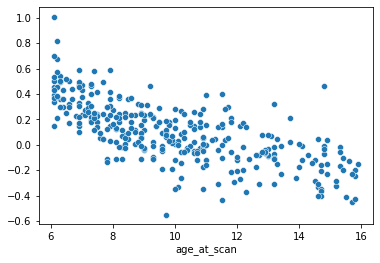

In [344]:
sns.scatterplot(data = Z_df, x = 'age_at_scan', y = Z_df[Z_cols].mean(axis =1))
plt.show()

## Export EV

In [195]:
blr_metrics.to_csv(os.path.join(data_dir, 'Outputs/blr_metrics.csv'), index = False)

# Plot trajectories

In [455]:
sex = 2

configuring dummy data ...
Running IDP 0 BG_THAL-AUDnet_PINS. :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([1.07634856]), 'Rho': array([-0.0621813]), 'pRho': array([0.66295906]), 'SMSE': array([1.89349323]), 'EXPV': array([-0.0270882])}


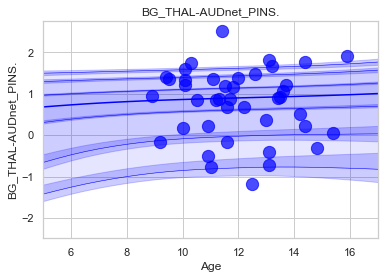

Running IDP 1 BG_THAL-LIMnet. :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.78821731]), 'Rho': array([0.06709094]), 'pRho': array([0.6381099]), 'SMSE': array([1.66764383]), 'EXPV': array([0.00154597])}


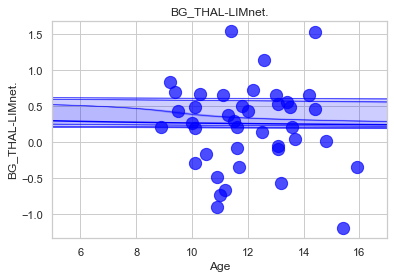

Running IDP 2 BG_THAL-DMnet_l. :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([1.2254516]), 'Rho': array([0.05981237]), 'pRho': array([0.67507949]), 'SMSE': array([3.57609091]), 'EXPV': array([-0.01720096])}


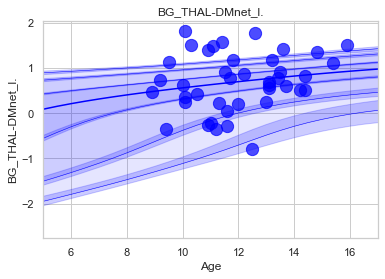

Running IDP 3 BG_THAL-VISnet. :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([1.23854934]), 'Rho': array([0.10419965]), 'pRho': array([0.46413517]), 'SMSE': array([1.9800113]), 'EXPV': array([0.00484825])}


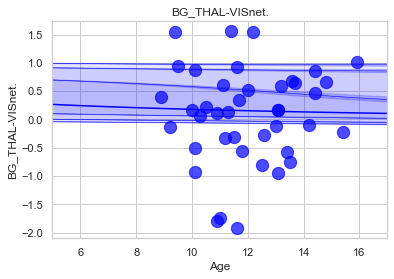

In [456]:
if (sex == 1): 
    clr = 'brown';
else:
    clr = 'blue'

# create dummy data for visualisation
print('configuring dummy data ...')
xx = np.arange(xmin, xmax, 0.5)
X0_dummy = np.zeros((len(xx), len(cols_cov)))
X0_dummy[:,0] = xx
X0_dummy[:,1] = sex

# create the design matrix
X_dummy = create_design_matrix(X0_dummy, xmin=xmin, xmax=xmax, 
                               site_ids=None, 
                               all_sites=site_ids_tr
                              )

# save the dummy covariates
cov_file_dummy = os.path.join(out_dir,'cov_bspline_dummy_mean.txt')
np.savetxt(cov_file_dummy, X_dummy)
sns.set(style='whitegrid')

for idp_num, idp in enumerate(idp_ids): 
    print('Running IDP', idp_num, idp, ':')
    idp_dir = os.path.join(out_dir, idp)
    os.chdir(idp_dir)

    # load the true data points
    yhat_te = load_2d(os.path.join(idp_dir, 'yhat_predict.txt'))
    s2_te = load_2d(os.path.join(idp_dir, 'ys2_predict.txt'))
    y_te = load_2d(os.path.join(idp_dir, 'resp_te.txt'))

    # set up the covariates for the dummy data
    print('Making predictions with dummy covariates (for visualisation)')
    yhat, s2 = predict(cov_file_dummy, 
                       alg = 'blr', 
                       respfile = None, 
                       model_path = os.path.join(idp_dir,'Models'), 
                       outputsuffix = '_dummy')

    # load the normative model
    with open(os.path.join(idp_dir,'Models', 'NM_0_0_estimate.pkl'), 'rb') as handle:
        nm = pickle.load(handle) 

    # get the warp and warp parameters
    W = nm.blr.warp
    warp_param = nm.blr.hyp[1:nm.blr.warp.get_n_params()+1] 

    # first, we warp predictions for the true data and compute evaluation metrics
    med_te = W.warp_predictions(np.squeeze(yhat_te), np.squeeze(s2_te), warp_param)[0]
    med_te = med_te[:, np.newaxis]
    print('metrics:', evaluate(y_te, med_te))

    # then, we warp dummy predictions to create the plots
    med, pr_int = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2), warp_param)

    # extract the different variance components to visualise
    beta, junk1, junk2 = nm.blr._parse_hyps(nm.blr.hyp, X_dummy)
    s2n = 1/beta # variation (aleatoric uncertainty)
    s2s = s2-s2n # modelling uncertainty (epistemic uncertainty)

    # plot the data points
    y_te_rescaled_all = np.zeros_like(y_te)
    for sid, site in enumerate(site_ids_te):
        # plot the true test data points 
        if all(elem in site_ids_tr for elem in site_ids_te):
            # all data in the test set are present in the training set

            # first, we select the data points belonging to this particular site
            idx = np.where(np.bitwise_and(X_te[:,2] == sex, X_te[:,sid+len(cols_cov)+1] !=0))[0]
            if len(idx) == 0:
                print('No data for site', sid, site, 'skipping...')
                continue

            # then directly adjust the data
            idx_dummy = np.bitwise_and(X_dummy[:,1] > X_te[idx,1].min(), X_dummy[:,1] < X_te[idx,1].max())
            y_te_rescaled = y_te[idx] - np.median(y_te[idx]) + np.median(med[idx_dummy])
        else:
            # we need to adjust the data based on the adaptation dataset 

            # first, select the data point belonging to this particular site
            idx = np.where(np.bitwise_and(X_te[:,2] == sex, (df_te['site'] == site).to_numpy()))[0]

            # load the adaptation data
            y_ad = load_2d(os.path.join(idp_dir, 'resp_ad.txt'))
            X_ad = load_2d(os.path.join(idp_dir, 'cov_bspline_ad.txt'))
            idx_a = np.where(np.bitwise_and(X_ad[:,2] == sex, (df_ad['site'] == site).to_numpy()))[0]
            if len(idx) < 2 or len(idx_a) < 2:
                print('Insufficent data for site', sid, site, 'skipping...')
                continue

            # adjust and rescale the data
            y_te_rescaled, s2_rescaled = nm.blr.predict_and_adjust(nm.blr.hyp, 
                                                                   X_ad[idx_a,:], 
                                                                   np.squeeze(y_ad[idx_a]), 
                                                                   Xs=None, 
                                                                   ys=np.squeeze(y_te[idx]))
        # plot the (adjusted) data points
        
        plt.scatter(X_te[idx,1], y_te_rescaled, s=150, color=clr, alpha = 0.7)
        
    # plot the median of the dummy data
    plt.plot(xx, med, clr)

    # fill the gaps in between the centiles
    junk, pr_int25 = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2), warp_param, percentiles=[0.25,0.75])
    junk, pr_int95 = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2), warp_param, percentiles=[0.05,0.95])
    junk, pr_int99 = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2), warp_param, percentiles=[0.01,0.99])
    plt.fill_between(xx, pr_int25[:,0], pr_int25[:,1], alpha = 0.1,color=clr)
    plt.fill_between(xx, pr_int95[:,0], pr_int95[:,1], alpha = 0.1,color=clr)
    plt.fill_between(xx, pr_int99[:,0], pr_int99[:,1], alpha = 0.1,color=clr)

    # make the width of each centile proportional to the epistemic uncertainty
    junk, pr_int25l = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2-0.5*s2s), warp_param, percentiles=[0.25,0.75])
    junk, pr_int95l = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2-0.5*s2s), warp_param, percentiles=[0.05,0.95])
    junk, pr_int99l = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2-0.5*s2s), warp_param, percentiles=[0.01,0.99])
    junk, pr_int25u = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2+0.5*s2s), warp_param, percentiles=[0.25,0.75])
    junk, pr_int95u = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2+0.5*s2s), warp_param, percentiles=[0.05,0.95])
    junk, pr_int99u = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2+0.5*s2s), warp_param, percentiles=[0.01,0.99])    
    plt.fill_between(xx, pr_int25l[:,0], pr_int25u[:,0], alpha = 0.2,color=clr)
    plt.fill_between(xx, pr_int95l[:,0], pr_int95u[:,0], alpha = 0.2,color=clr)
    plt.fill_between(xx, pr_int99l[:,0], pr_int99u[:,0], alpha = 0.2,color=clr)
    plt.fill_between(xx, pr_int25l[:,1], pr_int25u[:,1], alpha = 0.2,color=clr)
    plt.fill_between(xx, pr_int95l[:,1], pr_int95u[:,1], alpha = 0.2,color=clr)
    plt.fill_between(xx, pr_int99l[:,1], pr_int99u[:,1], alpha = 0.2,color=clr)

    # plot actual centile lines
    plt.plot(xx, pr_int25[:,0],color=clr, linewidth=0.5)
    plt.plot(xx, pr_int25[:,1],color=clr, linewidth=0.5)
    plt.plot(xx, pr_int95[:,0],color=clr, linewidth=0.5)
    plt.plot(xx, pr_int95[:,1],color=clr, linewidth=0.5)
    plt.plot(xx, pr_int99[:,0],color=clr, linewidth=0.5)
    plt.plot(xx, pr_int99[:,1],color=clr, linewidth=0.5)
    
#     plt.ylim(-1, 4)
    plt.xlabel('Age')
    plt.ylabel(idp) 
    plt.title(idp)
    plt.xlim((5,17))
    plt.savefig(os.path.join(idp_dir, 'centiles_' + str(sex)),  bbox_inches='tight')
    plt.show()

os.chdir(out_dir)

In [1115]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(blr_metrics.sort_values(by = 'EV', ascending = False))

                                      eid        NLL        EV       MSLL  \
26           lh_superiorfrontal_thickness -13.098165  0.719125  -1.555561   
44      rh_lateralorbitofrontal_thickness  -9.216480  0.706854  -2.236773   
57                 rh_precuneus_thickness -20.253930  0.703449  -6.486718   
27          lh_superiorparietal_thickness -19.297464  0.699923  -9.563528   
23                 lh_precuneus_thickness -20.510138  0.699187  -6.606118   
59      rh_rostralmiddlefrontal_thickness -12.125685  0.697391  -4.831340   
6           lh_inferiorparietal_thickness -18.834756  0.695212  -4.681864   
60           rh_superiorfrontal_thickness -25.958204  0.694591  -1.417526   
61          rh_superiorparietal_thickness -19.765601  0.690539  -9.865504   
63             rh_supramarginal_thickness -29.651171  0.678487  -4.402194   
40          rh_inferiorparietal_thickness -20.042290  0.656234  -4.818970   
29             lh_supramarginal_thickness -16.063892  0.648892  -3.326745   